## **Weather Forecasting Module**

Fetch daily weather history via the free Open-Meteo API, turn it into a pandas DataFrame, and leave a clean hook for later modeling (AR/MA).

In [2]:
import requests
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt

import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VARMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

DEFAULT_END = date.today()
DEFAULT_START = DEFAULT_END - timedelta(days=548)

### **Option 1: Load Existing Data (if data collection already done)**

If you already have the weather data, uncomment and modify the line below to load it:


In [3]:
# Uncomment and modify if you have existing data:
# weather_df = pd.read_csv('path/to/your/data.csv', index_col=0, parse_dates=True)
# OR if data is in a variable from a previous session, it will be detected automatically


### **Option 2: Fetch Data from API**


## **Data Collection**

In [4]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using Open-Meteo's free geocoding API."""
    url = "https://geocoding-api.open-meteo.com/v1/search"
    resp = requests.get(url, params={"name": city, "count": 1, "language": "en"}, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    results = data.get("results") or []
    if not results:
        raise ValueError(f"No geocoding results for '{city}'")
    lat = results[0]["latitude"]
    lon = results[0]["longitude"]
    return lat, lon


In [5]:
def fetch_weather_timeseries(city: str, start: date | None = None, end: date | None = None) -> pd.DataFrame:
    """
    Fetch daily weather history (avg/min/max temp, precip) for a city into a DataFrame.

    Uses Open-Meteo's archive API. Dates are inclusive and must be in YYYY-MM-DD.
    """
    start = start or DEFAULT_START
    end = end or DEFAULT_END
    
    # Ensure end date is not in the future (API limitation)
    today = date.today()
    if end > today:
        print(f"Warning: end date {end} is in the future. Using today ({today}) instead.")
        end = today
    
    if start > end:
        raise ValueError(f"start date ({start}) must be <= end date ({end})")

    lat, lon = geocode_city(city)

    url = "https://archive-api.open-meteo.com/v1/archive"
    # Open-Meteo API expects daily as a list
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start.isoformat(),
        "end_date": end.isoformat(),
        "daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "precipitation_sum"],
        "timezone": "auto",
    }

    resp = requests.get(url, params=params, timeout=20)
    if resp.status_code != 200:
        print(f"API Error: {resp.status_code}")
        print(f"URL: {resp.url}")
        print(f"Response: {resp.text[:500]}")
    resp.raise_for_status()
    data = resp.json()

    # Build DataFrame safely
    daily = data.get("daily", {})
    df = pd.DataFrame(daily)
    if df.empty:
        raise ValueError("No weather data returned; check dates or API availability")

    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.rename(
        columns={
            "temperature_2m_max": "temp_max_c",
            "temperature_2m_min": "temp_min_c",
            "temperature_2m_mean": "temp_mean_c",
            "precipitation_sum": "precip_mm",
        },
        inplace=True,
    )
    return df


In [6]:
# Check if weather_df already exists (data collection already done)
if 'weather_df' in globals() and globals()['weather_df'] is not None:
    weather_df = globals()['weather_df']
    if len(weather_df) > 0:
        print(f"✓ Using existing weather_df with {len(weather_df)} days")
        print(f"Data spans {weather_df.index.min().date()} to {weather_df.index.max().date()}")
        display(weather_df.head())
        display(weather_df.tail(3))
    else:
        print("weather_df exists but is empty. Fetching from API...")
        weather_df = None  # Will trigger fetch below
else:
    print("weather_df not found. Fetching from API...")
    weather_df = None  # Will trigger fetch below

# Fetch data if not available
if weather_df is None:
    print(f"Today's date: {date.today()}")
    print(f"Default date range: {DEFAULT_START} to {DEFAULT_END}")
    
    try:
        weather_df = fetch_weather_timeseries("Dubai")
        display(weather_df.head())
        display(weather_df.tail(3))
        print(f"✓ Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
    except Exception as exc:
        print(f"✗ Initial fetch failed: {exc}")
        print("\nTrying with a more conservative date range (last 3 years)...")
        try:
            # Try with a shorter, more recent date range
            end_date = date.today() - timedelta(days=1)  # Yesterday
            start_date = end_date - timedelta(days=1095)  # 3 years ago
            print(f"Trying date range: {start_date} to {end_date}")
            weather_df = fetch_weather_timeseries("Dubai", start=start_date, end=end_date)
            display(weather_df.head())
            display(weather_df.tail(3))
            print(f"✓ Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
        except Exception as exc2:
            print(f"✗ Fallback fetch also failed: {exc2}")
            print("\n" + "="*60)
            print("DATA LOADING INSTRUCTIONS:")
            print("="*60)
            print("Since data collection is already done, please load your data manually.")
            print("\nOption 1: If data is in a CSV file:")
            print("  weather_df = pd.read_csv('your_data.csv', index_col=0, parse_dates=True)")
            print("\nOption 2: If data is in a pickle file:")
            print("  weather_df = pd.read_pickle('your_data.pkl')")
            print("\nOption 3: If data is already in memory from a previous session,")
            print("  just run the cells above that define weather_df.")
            print("="*60)
            raise exc2


weather_df not found. Fetching from API...
Today's date: 2025-12-23
Default date range: 2024-06-23 to 2025-12-23


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2024-06-23,47.0,28.9,37.0,0.0
2024-06-24,47.8,29.6,37.0,0.0
2024-06-25,43.6,29.4,36.1,0.0
2024-06-26,42.8,29.4,35.6,0.0
2024-06-27,40.9,29.5,35.0,0.0


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-12-21,21.1,10.8,15.8,0.0
2025-12-22,22.5,12.6,17.0,0.0
2025-12-23,22.6,11.7,16.5,0.0


✓ Fetched 549 days spanning 2024-06-23 to 2025-12-23


## **Data Exploration and Cleaning**

In [7]:
# Basic structure
print(weather_df.info())
print(weather_df.describe())

# Missing values check
print("\nMissing values per column:")
print(weather_df.isna().sum())

# Quick correlation snapshot
corr = weather_df.corr()
print("\nCorrelation matrix:")
display(corr)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 549 entries, 2024-06-23 to 2025-12-23
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp_max_c   549 non-null    float64
 1   temp_min_c   549 non-null    float64
 2   temp_mean_c  549 non-null    float64
 3   precip_mm    549 non-null    float64
dtypes: float64(4)
memory usage: 21.4 KB
None
       temp_max_c  temp_min_c  temp_mean_c   precip_mm
count  549.000000  549.000000   549.000000  549.000000
mean    35.874863   23.906740    29.314026    0.101821
std      6.973149    5.942634     6.065221    1.566191
min     20.500000   10.200000    15.600000    0.000000
25%     30.500000   18.800000    24.000000    0.000000
50%     37.500000   25.400000    30.800000    0.000000
75%     41.800000   28.800000    34.500000    0.000000
max     47.900000   34.200000    39.200000   35.500000

Missing values per column:
temp_max_c     0
temp_min_c     0
temp_mean_c    0
preci

,temp_max_c,temp_min_c,temp_mean_c,precip_mm
temp_max_c,1.000000,0.904060,0.972176,-0.117908
temp_min_c,0.904060,1.000000,0.974437,-0.080879
temp_mean_c,0.972176,0.974437,1.000000,-0.094958
precip_mm,-0.117908,-0.080879,-0.094958,1.000000


<Figure size 640x480 with 0 Axes>

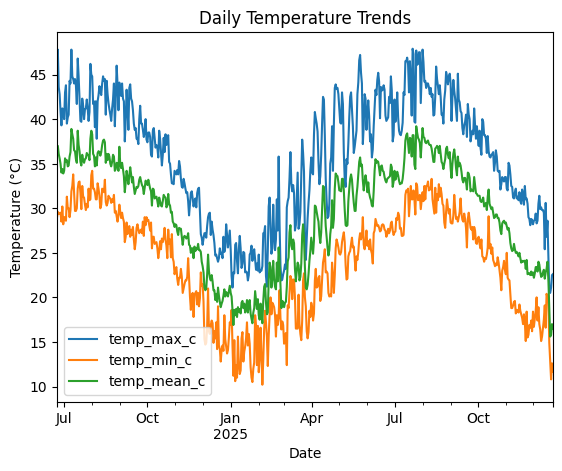

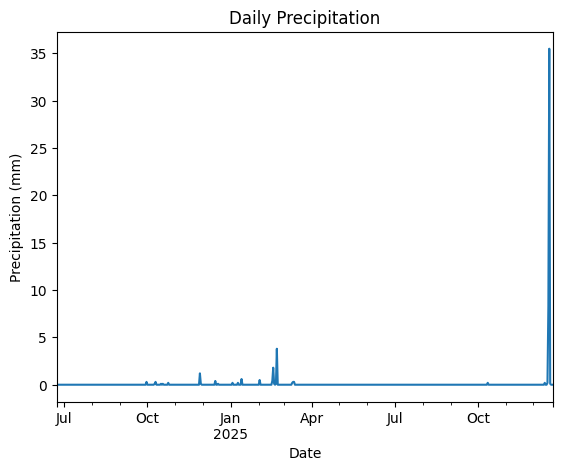

In [8]:
plt.figure()
weather_df[["temp_max_c", "temp_min_c", "temp_mean_c"]].plot()
plt.title("Daily Temperature Trends")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

plt.figure()
weather_df["precip_mm"].plot()
plt.title("Daily Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

In [9]:
df = weather_df.copy()

df["day_of_year"] = df.index.dayofyear

df["doy_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)

<Figure size 640x480 with 0 Axes>

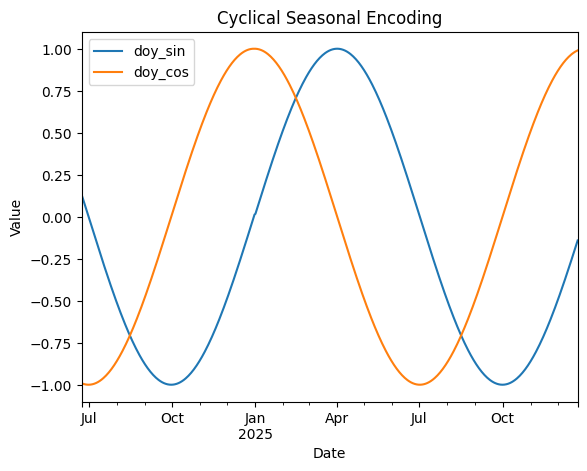

In [10]:
plt.figure()
df[["doy_sin", "doy_cos"]].plot()
plt.title("Cyclical Seasonal Encoding")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

### **Dataset Split**

In [11]:
# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Sort by time (important safeguard)
df = df.sort_index()

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df)

train_end = int(n * train_ratio)
val_end = train_end + int(n * val_ratio)


train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

assert train_df.index.max() < val_df.index.min()
assert val_df.index.max() < test_df.index.min()

## **Model 1: Naive Seasonal Baseline**


In [12]:
def naive_seasonal_forecast(train_data, test_data, target_col='temp_mean_c', seasonal_period=365):
    """
    Naive seasonal baseline: forecast using the value from the same day of year
    in the training set (or average of multiple years if available).
    """
    predictions = []
    
    for test_date in test_data.index:
        day_of_year = test_date.dayofyear
        
        # Find matching days in training data
        train_matches = train_data[train_data.index.dayofyear == day_of_year]
        
        if len(train_matches) > 0:
            # Use mean of all matching days from training set
            pred = train_matches[target_col].mean()
        else:
            # Fallback: use overall training mean
            pred = train_data[target_col].mean()
        
        predictions.append(pred)
    
    return pd.Series(predictions, index=test_data.index)

# Generate forecasts for all target variables
naive_preds = {}
for target in ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']:
    naive_preds[target] = naive_seasonal_forecast(train_df, test_df, target_col=target)

print("Naive seasonal baseline forecasts generated")
print(f"Sample predictions for temp_mean_c:")
display(naive_preds['temp_mean_c'].head())


Naive seasonal baseline forecasts generated
Sample predictions for temp_mean_c:


time
2025-10-02    32.6
2025-10-03    33.2
2025-10-04    32.7
2025-10-05    32.2
2025-10-06    31.9
dtype: float64

In [13]:
def clean_series(series: pd.Series) -> pd.Series:
    # fill gaps to avoid NaNs after differencing
    s = series.copy()
    s = s.interpolate(limit_direction="both")
    s = s.bfill().ffill()
    return s

def fit_and_forecast(train_df, test_df, target, seasonal_order=(0,1,1,7), maxiter=30):
    # index sanity
    print(f"\n=== {target} ===")
    train_local = train_df.asfreq("D")
    test_local = test_df.asfreq("D")
    print("Index monotonic:", train_local.index.is_monotonic_increasing,
          " | Duplicates:", train_local.index.has_duplicates)
    
    series = clean_series(train_local[target])
    print("NaNs after clean:", series.isna().sum())
    
    # primary model
    mod = SARIMAX(series, order=(1,1,1), seasonal_order=seasonal_order,
                  enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit(method="lbfgs", disp=False, maxiter=maxiter)
    conv = res.mle_retvals.get("converged")
    warn = res.mle_retvals.get("warnflag")
    print("Converged:", conv, " Warnflag:", warn)
    
    preds = res.forecast(steps=len(test_local))
    print("Forecast NaNs:", preds.isna().sum())
    print("Head:\n", preds.head())
    
    # fallback if NaNs persist
    if preds.isna().any():
        print("Fallback: simpler non-seasonal model (0,1,1)")
        mod2 = SARIMAX(series, order=(0,1,1), seasonal_order=(0,0,0,0),
                       enforce_stationarity=False, enforce_invertibility=False)
        res2 = mod2.fit(method="lbfgs", disp=False, maxiter=maxiter)
        preds2 = res2.forecast(steps=len(test_local))
        print("Fallback converged:", res2.mle_retvals.get("converged"),
              " NaNs:", preds2.isna().sum())
        print("Fallback head:\n", preds2.head())
        return res2, preds2
    return res, preds

# Example usage before your main loop:
for target in ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']:
     _, _ = fit_and_forecast(train_df, test_df, target, seasonal_order=(0,1,1,7), maxiter=30)


=== temp_max_c ===
Index monotonic: True  | Duplicates: False
NaNs after clean: 0
Converged: True  Warnflag: 0
Forecast NaNs: 0
Head:
 2025-07-12    42.151148
2025-07-13    41.695549
2025-07-14    41.814076
2025-07-15    41.409591
2025-07-16    41.325411
Freq: D, Name: predicted_mean, dtype: float64

=== temp_min_c ===
Index monotonic: True  | Duplicates: False
NaNs after clean: 0
Converged: True  Warnflag: 0
Forecast NaNs: 0
Head:
 2025-07-12    27.441603
2025-07-13    27.741418
2025-07-14    27.896435
2025-07-15    28.016708
2025-07-16    27.855530
Freq: D, Name: predicted_mean, dtype: float64

=== temp_mean_c ===
Index monotonic: True  | Duplicates: False
NaNs after clean: 0
Converged: True  Warnflag: 0
Forecast NaNs: 0
Head:
 2025-07-12    34.329863
2025-07-13    34.346566
2025-07-14    34.652095
2025-07-15    34.591731
2025-07-16    34.333522
Freq: D, Name: predicted_mean, dtype: float64

=== precip_mm ===
Index monotonic: True  | Duplicates: False
NaNs after clean: 0
Converged: 

## **Model 2: AR / SARIMAX**


In [22]:
def fit_sarimax_once(series, order=(0,1,1), seasonal_order=(0,0,0,0), maxiter=50):
    mod = SARIMAX(
        series,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = mod.fit(method="lbfgs", disp=False, maxiter=maxiter)
    return res

def run_sarimax_for_target(
    train_df,
    test_df,
    target,
    primary_order=(0,1,1),
    primary_seasonal=(0,1,1,7),
    fallback_order=(0,1,1),
    fallback_seasonal=(0,0,0,0),
    maxiter=50,
):
    train_local = train_df.asfreq("D")
    test_local = test_df.asfreq("D")
    series = clean_series(train_local[target])

    print(f"\n=== {target} ===")
    preds_series = None
    model_used = None

    def _forecast(res):
        fc = res.get_forecast(steps=len(test_local))
        return pd.Series(fc.predicted_mean, index=test_local.index)

    # Primary fit (weekly seasonality)
    try:
        res = fit_sarimax_once(series, order=primary_order, seasonal_order=primary_seasonal, maxiter=maxiter)
        conv = res.mle_retvals.get("converged")
        warn = res.mle_retvals.get("warnflag")
        print(f"primary order={primary_order}, seasonal={primary_seasonal} converged={conv} warn={warn}")
        preds_series = _forecast(res)
        model_used = res
    except Exception as e:
        print(f"primary fit failed: {e}")

    # Fallback if needed
    if preds_series is None or preds_series.isna().any():
        print("-> using fallback non-seasonal model to avoid NaNs")
        try:
            res_fb = fit_sarimax_once(series, order=fallback_order, seasonal_order=fallback_seasonal, maxiter=maxiter)
            fb_conv = res_fb.mle_retvals.get("converged")
            fb_warn = res_fb.mle_retvals.get("warnflag")
            print(f"fallback order={fallback_order}, seasonal={fallback_seasonal} converged={fb_conv} warn={fb_warn}")
            preds_series = _forecast(res_fb)
            model_used = res_fb
        except Exception as e:
            print(f"fallback fit failed: {e}")
            preds_series = None

    # Final safety: fill any residual NaNs with last observation/forward fill
    if preds_series is not None:
        if preds_series.isna().any():
            preds_series = preds_series.bfill().ffill()
            preds_series = preds_series.fillna(series.iloc[-1])
        if target == 'precip_mm':
            preds_series = preds_series.clip(lower=0)

    return model_used, preds_series

# Fit SARIMAX models for each target variable
sarimax_models = {}
sarimax_preds = {}

print("Fitting SARIMAX models (primary weekly seasonality, fallback non-seasonal)...")

for target in ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']:
    model, preds = run_sarimax_for_target(
        train_df,
        test_df,
        target,
        primary_order=(0,1,1),
        primary_seasonal=(0,1,1,7),
        fallback_order=(0,1,1),
        fallback_seasonal=(0,0,0,0),
        maxiter=50,
    )
    sarimax_models[target] = model
    sarimax_preds[target] = preds

print("\nSARIMAX models fitted")
print("Sample predictions for temp_mean_c:")
if sarimax_preds.get('temp_mean_c') is not None:
    display(sarimax_preds['temp_mean_c'].head())
else:
    print("  Model failed to generate predictions")


Fitting SARIMAX models (primary weekly seasonality, fallback non-seasonal)...

=== temp_max_c ===
primary order=(0, 1, 1), seasonal=(0, 1, 1, 7) converged=True warn=0
-> using fallback non-seasonal model to avoid NaNs
fallback order=(0, 1, 1), seasonal=(0, 0, 0, 0) converged=True warn=0

=== temp_min_c ===
primary order=(0, 1, 1), seasonal=(0, 1, 1, 7) converged=True warn=0
-> using fallback non-seasonal model to avoid NaNs
fallback order=(0, 1, 1), seasonal=(0, 0, 0, 0) converged=True warn=0

=== temp_mean_c ===
primary order=(0, 1, 1), seasonal=(0, 1, 1, 7) converged=True warn=0
-> using fallback non-seasonal model to avoid NaNs
fallback order=(0, 1, 1), seasonal=(0, 0, 0, 0) converged=True warn=0

=== precip_mm ===
primary order=(0, 1, 1), seasonal=(0, 1, 1, 7) converged=True warn=0
-> using fallback non-seasonal model to avoid NaNs
fallback order=(0, 1, 1), seasonal=(0, 0, 0, 0) converged=True warn=0

SARIMAX models fitted
Sample predictions for temp_mean_c:


time
2025-10-02    34.422698
2025-10-03    34.422698
2025-10-04    34.422698
2025-10-05    34.422698
2025-10-06    34.422698
Freq: D, Name: predicted_mean, dtype: float64

## **Model 3: VARMAX with Cyclical Features**


In [23]:
def fit_varmax_model(train_data, target_cols=None, exog_cols=None, order=(1,0)):
    """
    Fit VARMAX model with exogenous variables (cyclical features).
    target_cols: list of target variables to model
    exog_cols: list of exogenous variables (cyclical features)
    order: (p, q) for VARMA
    """
    if target_cols is None:
        target_cols = ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']
    if exog_cols is None:
        exog_cols = ['doy_sin', 'doy_cos']
    
    # Prepare data
    endog = train_data[target_cols].copy()
    exog = train_data[exog_cols].copy() if exog_cols else None
    
    try:
        model = VARMAX(
            endog,
            exog=exog,
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted_model = model.fit(disp=False, maxiter=50)
        return fitted_model
    except Exception as e:
        print(f"Error fitting VARMAX: {e}")
        # Try simpler model
        try:
            model = VARMAX(
                endog,
                exog=exog,
                order=(1,0),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fitted_model = model.fit(disp=False, maxiter=50)
            return fitted_model
        except Exception as e2:
            print(f"Fallback VARMAX model also failed: {e2}")
            return None

def forecast_varmax(fitted_model, n_periods, exog_future=None):
    """Generate forecasts from fitted VARMAX model."""
    if fitted_model is None:
        return None
    try:
        forecast = fitted_model.forecast(steps=n_periods, exog=exog_future)
        return forecast
    except Exception as e:
        print(f"VARMAX forecast error: {e}")
        return None

# Fit VARMAX model
print("Fitting VARMAX model with cyclical features...")
varmax_model = fit_varmax_model(
    train_df,
    target_cols=['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm'],
    exog_cols=['doy_sin', 'doy_cos'],
    order=(1,0)
)

# Generate forecasts
varmax_preds = {}
if varmax_model is not None:
    # Prepare exogenous variables for test period
    exog_test = test_df[['doy_sin', 'doy_cos']].copy()
    
    forecast_df = forecast_varmax(varmax_model, len(test_df), exog_future=exog_test)
    
    if forecast_df is not None:
        for target in ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']:
            if target in forecast_df.columns:
                varmax_preds[target] = pd.Series(forecast_df[target].values, index=test_df.index)
            else:
                varmax_preds[target] = None
    else:
        for target in ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']:
            varmax_preds[target] = None
else:
    for target in ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']:
        varmax_preds[target] = None

print("\nVARMAX model fitted")
print(f"Sample predictions for temp_mean_c:")
if varmax_preds['temp_mean_c'] is not None:
    display(varmax_preds['temp_mean_c'].head())
else:
    print("  Model failed to generate predictions")


Fitting VARMAX model with cyclical features...


/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



VARMAX model fitted
Sample predictions for temp_mean_c:


/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1719: RuntimeWarning: invalid value encountered in dot
  np.dot(self.design[:, :, design_t],
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1705: RuntimeWarning: invalid value encountered in dot
  self.forecasts[:, t] = np.dot(


time
2025-10-02   -7.019952e+05
2025-10-03    1.044846e+10
2025-10-04   -1.282561e+14
2025-10-05    1.596574e+18
2025-10-06   -1.984891e+22
dtype: float64

## **Model 4: Gradient Boosting with Lag Features**


In [24]:
def create_lag_features(df, target_col, lags=[1, 7, 30, 365]):
    """
    Create lag features for a target variable.
    """
    df_lagged = df.copy()
    
    for lag in lags:
        df_lagged[f'{target_col}_lag_{lag}'] = df_lagged[target_col].shift(lag)
    
    return df_lagged

def prepare_gb_data(train_data, val_data, test_data, target_col='temp_mean_c', 
                   lags=[1, 7, 30, 365], exog_cols=None):
    """
    Prepare data for gradient boosting with lag features and cyclical features.
    """
    if exog_cols is None:
        exog_cols = ['doy_sin', 'doy_cos']
    
    # Combine all data to create lags properly
    all_data = pd.concat([train_data, val_data, test_data]).sort_index()
    
    # Create lag features
    all_data_lagged = create_lag_features(all_data, target_col, lags)
    
    # Select features
    feature_cols = [f'{target_col}_lag_{lag}' for lag in lags] + exog_cols
    
    # Split back
    train_end_idx = len(train_data)
    val_end_idx = train_end_idx + len(val_data)
    
    X_train = all_data_lagged[feature_cols].iloc[:train_end_idx].dropna()
    y_train = all_data_lagged[target_col].iloc[:train_end_idx].loc[X_train.index]
    
    X_val = all_data_lagged[feature_cols].iloc[train_end_idx:val_end_idx].dropna()
    y_val = all_data_lagged[target_col].iloc[train_end_idx:val_end_idx].loc[X_val.index]
    
    X_test = all_data_lagged[feature_cols].iloc[val_end_idx:].dropna()
    y_test = all_data_lagged[target_col].iloc[val_end_idx:].loc[X_test.index]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def fit_gb_model(X_train, y_train, X_val=None, y_val=None):
    """
    Fit gradient boosting model.
    """
    model = HistGradientBoostingRegressor(
        max_iter=200,
        learning_rate=0.1,
        max_depth=10,
        random_state=42,
        validation_fraction=None  # We'll use separate validation set
    )
    
    if X_val is not None and y_val is not None:
        model.fit(X_train, y_train)
        # Could add early stopping here if needed
    else:
        model.fit(X_train, y_train)
    
    return model

def forecast_gb_rolling(model, train_data, test_data, target_col='temp_mean_c',
                       lags=[1, 7, 30, 365], exog_cols=None):
    """
    Generate rolling forecasts using gradient boosting model.
    This is necessary because we need to update lag features as we forecast.
    """
    if exog_cols is None:
        exog_cols = ['doy_sin', 'doy_cos']
    
    # Start with full history
    history = train_data.copy()
    predictions = []
    
    for test_date in test_data.index:
        # Create lag features from current history
        history_lagged = create_lag_features(history, target_col, lags)
        
        # Get features for this date
        feature_cols = [f'{target_col}_lag_{lag}' for lag in lags] + exog_cols
        
        # Get the last row (most recent)
        if len(history_lagged) > 0:
            X_pred = history_lagged[feature_cols].iloc[[-1]].dropna()
            
            if len(X_pred) > 0:
                pred = model.predict(X_pred)[0]
            else:
                # Fallback: use mean of training data
                pred = train_data[target_col].mean()
        else:
            pred = train_data[target_col].mean()
        
        predictions.append(pred)
        
        # Update history with prediction (for next iteration)
        # Create a temporary row with the prediction
        new_row = test_data.loc[[test_date]].copy()
        new_row[target_col] = pred
        history = pd.concat([history, new_row]).sort_index()
    
    return pd.Series(predictions, index=test_data.index)

# Fit gradient boosting models for each target
gb_models = {}
gb_preds = {}

print("Fitting Gradient Boosting models with lag features...")
for target in ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']:
    print(f"  Fitting {target}...")
    
    # Prepare data
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_gb_data(
        train_df, val_df, test_df, 
        target_col=target,
        lags=[1, 7, 30, 365],
        exog_cols=['doy_sin', 'doy_cos']
    )
    
    # Fit model
    model = fit_gb_model(X_train, y_train, X_val, y_val)
    gb_models[target] = model
    
    # Generate forecasts using rolling approach
    preds = forecast_gb_rolling(
        model, train_df, test_df,
        target_col=target,
        lags=[1, 7, 30, 365],
        exog_cols=['doy_sin', 'doy_cos']
    )
    gb_preds[target] = preds

print("\nGradient Boosting models fitted")
print(f"Sample predictions for temp_mean_c:")
display(gb_preds['temp_mean_c'].head())


Fitting Gradient Boosting models with lag features...
  Fitting temp_max_c...
  Fitting temp_min_c...
  Fitting temp_mean_c...
  Fitting precip_mm...

Gradient Boosting models fitted
Sample predictions for temp_mean_c:


time
2025-10-02    33.5
2025-10-03    33.5
2025-10-04    33.5
2025-10-05    33.5
2025-10-06    33.5
dtype: float64

## **Model 5: Compare All Models on Test Set**


In [30]:
def calculate_metrics(y_true, y_pred, model_name, target_name):
    """Calculate MAE, RMSE, and MAPE for a model."""
    if y_pred is None or len(y_pred) == 0:
        return {
            'model': model_name,
            'target': target_name,
            'mae': np.nan,
            'rmse': np.nan,
            'mape': np.nan
        }
    
    # Align indices
    common_idx = y_true.index.intersection(y_pred.index)
    if len(common_idx) == 0:
        return {
            'model': model_name,
            'target': target_name,
            'mae': np.nan,
            'rmse': np.nan,
            'mape': np.nan
        }
    
    y_true_aligned = y_true.loc[common_idx]
    y_pred_aligned = y_pred.loc[common_idx]

    # Drop NaNs in either series to avoid metric errors
    not_na = ~(y_true_aligned.isna() | y_pred_aligned.isna())
    y_true_aligned = y_true_aligned[not_na]
    y_pred_aligned = y_pred_aligned[not_na]
    if len(y_true_aligned) == 0:
        return {
            'model': model_name,
            'target': target_name,
            'mae': np.nan,
            'rmse': np.nan,
            'mape': np.nan
        }
    
    mae = mean_absolute_error(y_true_aligned, y_pred_aligned)
    rmse = np.sqrt(mean_squared_error(y_true_aligned, y_pred_aligned))
    
    # MAPE (handle division by zero)
    mask = y_true_aligned != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true_aligned[mask] - y_pred_aligned[mask]) / y_true_aligned[mask])) * 100
    else:
        mape = np.nan
    
    return {
        'model': model_name,
        'target': target_name,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

# Compare all models
results = []

targets = ['temp_max_c', 'temp_min_c', 'temp_mean_c', 'precip_mm']
models_dict = {
    'Naive Seasonal': naive_preds,
    'SARIMAX': sarimax_preds,
    'VARMAX': varmax_preds,
    'Gradient Boosting': gb_preds
}

print("Calculating metrics for all models...\n")

for target in targets:
    y_true = test_df[target]
    
    for model_name, preds_dict in models_dict.items():
        y_pred = preds_dict.get(target)
        metrics = calculate_metrics(y_true, y_pred, model_name, target)
        results.append(metrics)

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.pivot_table(
    index='model',
    columns='target',
    values=['mae', 'rmse', 'mape'],
    aggfunc='first'
)

print("=" * 80)
print("MODEL COMPARISON RESULTS")
print("=" * 80)
display(results_df)

# Also show a summary by averaging across all targets
print("\n" + "=" * 80)
print("AVERAGE METRICS ACROSS ALL TARGETS")
print("=" * 80)
summary = results_df.mean(axis=1)
display(summary)


Calculating metrics for all models...

MODEL COMPARISON RESULTS


/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/sklearn/metrics/_regression.py:584: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/sklearn/metrics/_regression.py:584: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/sklearn/metrics/_regression.py:584: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/sklearn/metrics/_regression.py:584: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_

mae                                               \
target                 precip_mm     temp_max_c    temp_mean_c     temp_min_c   
model                                                                           
Gradient Boosting   5.361446e-01   8.711668e+00   7.795181e+00   7.579201e+00   
Naive Seasonal      5.650602e-01   1.649398e+00   1.585542e+00   2.507229e+00   
SARIMAX             5.386876e-01   1.115864e+01   8.717879e+00   6.814857e+00   
VARMAX             2.128878e+302  2.236098e+302  9.027035e+302  7.593041e+302   

                            mape                                               \
target                 precip_mm     temp_max_c    temp_mean_c     temp_min_c   
model                                                                           
Gradient Boosting   1.000000e+02   2.988766e+01   3.357450e+01   4.317978e+01   
Naive Seasonal      9.995305e+01   5.476111e+00   6.633423e+00   1.318091e+01   
SARIMAX             9.875397e+01   3.772515e+01   3.725358e+01   3.921307e+01   
VARMAX             3.938108e+306  8.803435e+302  4.084617e+303  3.975444e+303   

                       rmse                                    
target            precip_mm temp_max_c temp_mean_c temp_min_c  
model                                                          
Gradient Boosting  4.001912   9.661932    8.667027   8.510428  
Naive Seasonal     3.993896   2.051241    1.880015   2.959587  
SARIMAX            4.001515  11.915324    9.505468   7.824179  
VARMAX                  inf        inf         inf        inf


AVERAGE METRICS ACROSS ALL TARGETS


model
Gradient Boosting    21.842119
Naive Seasonal       11.869622
SARIMAX              22.785193
VARMAX                     inf
dtype: float64

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/sklearn/metrics/_regression.py:584: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


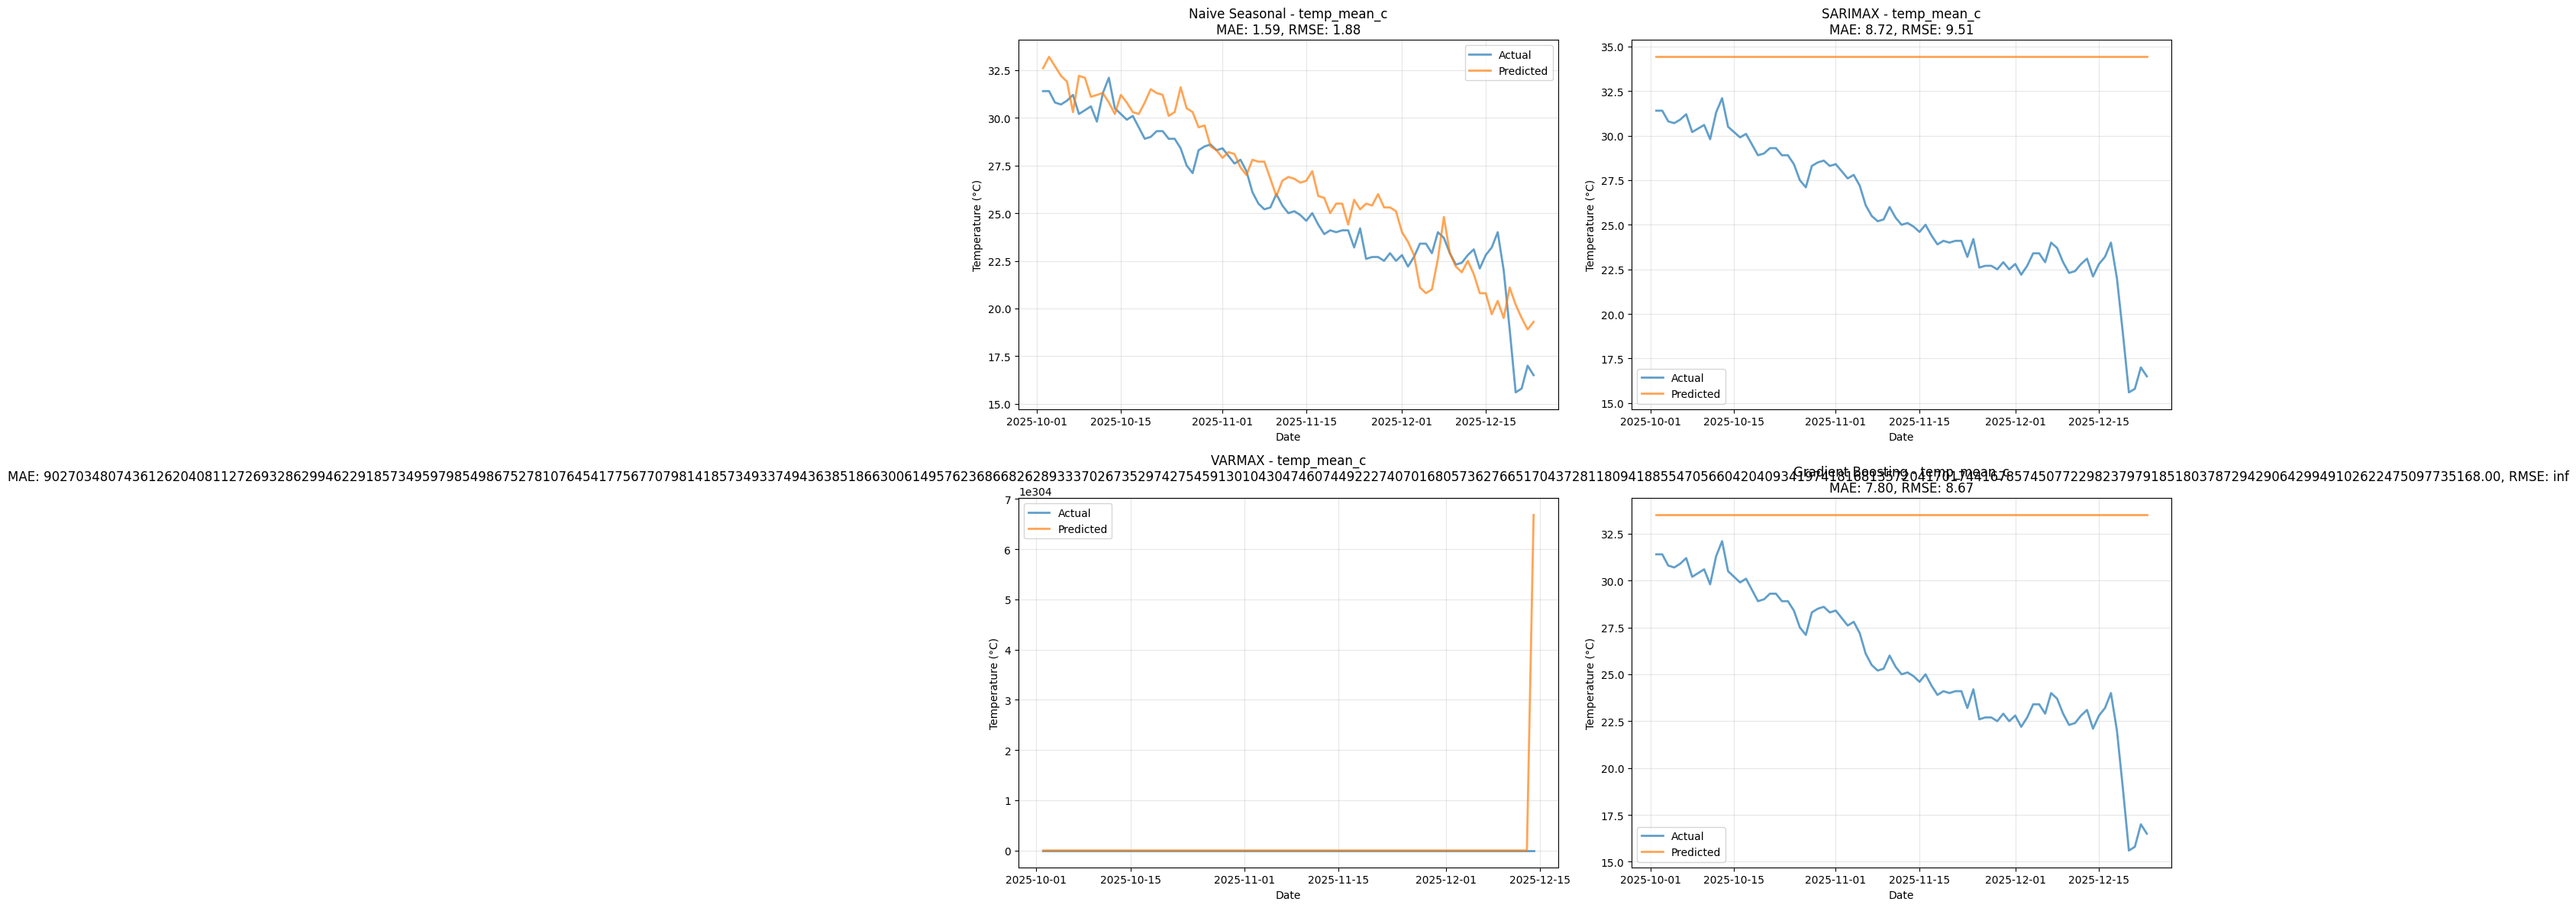

In [32]:
# Visualize predictions vs actuals for temp_mean_c
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

target = 'temp_mean_c'
y_true = test_df[target]

for idx, (model_name, preds_dict) in enumerate(models_dict.items()):
    ax = axes[idx]
    y_pred = preds_dict.get(target)
    
    if y_pred is not None and len(y_pred) > 0:
        # Align indices
        common_idx = y_true.index.intersection(y_pred.index)
        if len(common_idx) > 0:
            y_true_plot = y_true.loc[common_idx]
            y_pred_plot = y_pred.loc[common_idx]
            # drop NaNs before metrics/plotting
            not_na = ~(y_true_plot.isna() | y_pred_plot.isna())
            y_true_plot = y_true_plot[not_na]
            y_pred_plot = y_pred_plot[not_na]
            if len(y_true_plot) > 0:
                ax.plot(y_true_plot.index, y_true_plot.values, label='Actual', alpha=0.7, linewidth=2)
                ax.plot(y_pred_plot.index, y_pred_plot.values, label='Predicted', alpha=0.7, linewidth=2)
                ax.set_title(f'{model_name} - {target}')
                ax.set_xlabel('Date')
                ax.set_ylabel('Temperature (°C)')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                # Add metrics to title
                mae = mean_absolute_error(y_true_plot, y_pred_plot)
                rmse = np.sqrt(mean_squared_error(y_true_plot, y_pred_plot))
                ax.set_title(f'{model_name} - {target}\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
            else:
                ax.text(0.5, 0.5, 'No valid predictions', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{model_name} - {target}')
        else:
            ax.text(0.5, 0.5, 'No valid predictions', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model_name} - {target}')
    else:
        ax.text(0.5, 0.5, 'Model failed', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model_name} - {target}')

plt.tight_layout()
plt.show()


In [33]:
# Create a detailed comparison table for each target
print("=" * 80)
print("DETAILED METRICS BY TARGET VARIABLE")
print("=" * 80)

for target in targets:
    print(f"\n{target.upper()}:")
    print("-" * 80)
    
    target_results = [r for r in results if r['target'] == target]
    target_df = pd.DataFrame(target_results)[['model', 'mae', 'rmse', 'mape']]
    target_df = target_df.sort_values('mae')
    display(target_df)
    
    # Highlight best model
    if not target_df['mae'].isna().all():
        best_model = target_df.loc[target_df['mae'].idxmin(), 'model']
        print(f"  Best model (lowest MAE): {best_model}")


DETAILED METRICS BY TARGET VARIABLE

TEMP_MAX_C:
--------------------------------------------------------------------------------


,model,mae,rmse,mape
0,Naive Seasonal,1.649398e+00,2.051241,5.476111e+00
3,Gradient Boosting,8.711668e+00,9.661932,2.988766e+01
1,SARIMAX,1.115864e+01,11.915324,3.772515e+01
2,VARMAX,2.236098e+302,inf,8.803435e+302


  Best model (lowest MAE): Naive Seasonal

TEMP_MIN_C:
--------------------------------------------------------------------------------


,model,mae,rmse,mape
0,Naive Seasonal,2.507229e+00,2.959587,1.318091e+01
1,SARIMAX,6.814857e+00,7.824179,3.921307e+01
3,Gradient Boosting,7.579201e+00,8.510428,4.317978e+01
2,VARMAX,7.593041e+302,inf,3.975444e+303


  Best model (lowest MAE): Naive Seasonal

TEMP_MEAN_C:
--------------------------------------------------------------------------------


,model,mae,rmse,mape
0,Naive Seasonal,1.585542e+00,1.880015,6.633423e+00
3,Gradient Boosting,7.795181e+00,8.667027,3.357450e+01
1,SARIMAX,8.717879e+00,9.505468,3.725358e+01
2,VARMAX,9.027035e+302,inf,4.084617e+303


  Best model (lowest MAE): Naive Seasonal

PRECIP_MM:
--------------------------------------------------------------------------------


,model,mae,rmse,mape
3,Gradient Boosting,5.361446e-01,4.001912,1.000000e+02
1,SARIMAX,5.386876e-01,4.001515,9.875397e+01
0,Naive Seasonal,5.650602e-01,3.993896,9.995305e+01
2,VARMAX,2.128878e+302,inf,3.938108e+306


  Best model (lowest MAE): Gradient Boosting
